# VQA v2.0 Interactive Notebook

## Import Libraries

In [1]:
# Import libraries
import importlib
import os
from collections import Counter
from typing import Iterable

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from transformers import BertTokenizerFast


In [2]:
# Check GPU
if not torch.cuda.is_available():
    raise RuntimeError("GPU with CUDA support is required")
device = torch.device("cuda")


In [3]:
# Import utils
if not os.path.exists("./utils"):
    !git clone https://github.com/ZhangShaozuo/Artificial_Intelligence_VQA.git
    !ln -s ./DL-BigProject-VQA/utils ./utils

if os.path.exists("./DL-BigProject-VQA/utils"):
    !cd ./DL-BigProject-VQA/utils && git pull

import utils.data as data_util
import utils.helper as helper
import utils.train as train_util
from utils.vocab import Vocab

importlib.reload(data_util)
importlib.reload(helper)
importlib.reload(train_util)
pass


## Load Dataset

In [4]:
# Load dataset (single word answer only)
image_transform = transforms.Compose(
    [
        transforms.Resize(int(224 / 0.875)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

answer_vocab = Vocab({})


def answer_tansform(answer: str):
    return answer_vocab[answer]


def answer_tansform_factory(corpus: Iterable[str]):
    global answer_vocab
    answer_vocab = Vocab(Counter(corpus), specials=["<unk>"], min_freq=10)
    return answer_tansform


train_dataset = data_util.VQA2Dataset(
    "./VQA2/",
    group="train",
    image_transform=image_transform,
    answer_transform_factory=answer_tansform_factory,
    download=True,
)

valid_dataset = data_util.VQA2Dataset(
    "./VQA2/",
    group="val",
    image_transform=image_transform,
    answer_transform=answer_tansform,
)

test_dataset = data_util.VQA2Dataset(
    "./VQA2/",
    group="test",
    image_transform=image_transform,
    answer_transform=answer_tansform,
)

print("train_dataset:", len(train_dataset))
print("valid_dataset:", len(valid_dataset))
print("test_dataset:", len(test_dataset))
print("answer_vocab size:  ", len(answer_vocab))


train_dataset: 411198
valid_dataset: 138617
test_dataset: 59678
answer_vocab size:   1823


## Create Dataloader

In [5]:
# Create dataloader
batch_size = 16
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

def generate_batch(data_batch):
    images, questions, answers = zip(*data_batch)
    images = torch.stack(images, 0).to(device)
    question_inputs = tokenizer(list(questions), padding=True)
    question_inputs = {k: torch.tensor(v, dtype=torch.long).to(device) for k, v in question_inputs.items()}
    answers = torch.tensor(answers, dtype=torch.long).to(device)
    return images, question_inputs, answers


train_loader = DataLoader(
    train_dataset, batch_size=batch_size, collate_fn=generate_batch, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=batch_size, collate_fn=generate_batch
)

# use a subset of the validation dataset
mini_valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    collate_fn=generate_batch,
    sampler=SubsetRandomSampler(list(range(512))),
)

test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=generate_batch, shuffle=True)


Q: [CLS] what utensil can be seen? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
A: spoon


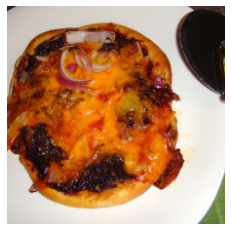

Q: [CLS] what is behind the zebra? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
A: field


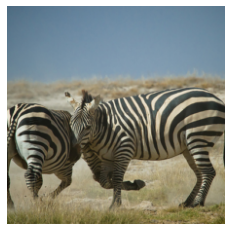

Q: [CLS] if the dog sees the disk will he know what comes next? [SEP]
A: yes


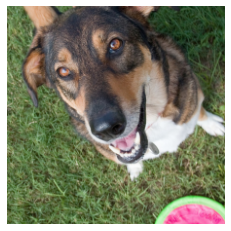

Q: [CLS] how many bottles are on the shelf? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
A: 2


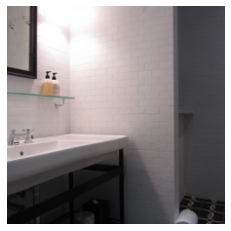

In [6]:
# Visualize some samples
def visualize_samples(images, questions, answers, max_num=-1):
    if max_num < 0:
        max_num = len(images)

    for _, v, q, a in zip(range(max_num), images, questions["input_ids"], answers):
        print("Q:", tokenizer.decode(q))
        print("A:", answer_vocab.itos[a])
        helper.imshow(v.cpu())
        plt.show()


images, questions, answers = next(iter(train_loader))
visualize_samples(images, questions, answers, max_num=4)


## Create Model

In [8]:
from models.bert_resnet152_mul_model import VQANet

model = VQANet(len(answer_vocab)).to(device)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Train Model

Epoch: 1/4 @ 2021-08-03 11:07:08.834019
12850/12850 [==============================] - 10550s 821ms/step - loss: 2.041 - accuracy: 0.421 - topk_accuracy: 0.799 - val_loss: 1.955 - val_accuracy: 0.438 - val_topk_accuracy: 0.793 - saved to checkpoints\2021-08-03_11-07\ckpt_00.pth
Epoch: 2/4 @ 2021-08-03 14:02:59.310290
12850/12850 [==============================] - 10605s 825ms/step - loss: 1.697 - accuracy: 0.482 - topk_accuracy: 0.845 - val_loss: 1.618 - val_accuracy: 0.477 - val_topk_accuracy: 0.838 - saved to checkpoints\2021-08-03_11-07\ckpt_01.pth
Epoch: 3/4 @ 2021-08-03 16:59:44.217763
12850/12850 [==============================] - 10673s 831ms/step - loss: 1.510 - accuracy: 0.516 - topk_accuracy: 0.870 - val_loss: 1.550 - val_accuracy: 0.518 - val_topk_accuracy: 0.865 - saved to checkpoints\2021-08-03_11-07\ckpt_02.pth
Epoch: 4/4 @ 2021-08-03 19:57:36.896394
12850/12850 [==============================] - 10759s 837ms/step - loss: 1.385 - accuracy: 0.562 - topk_accuracy: 0.886 - v

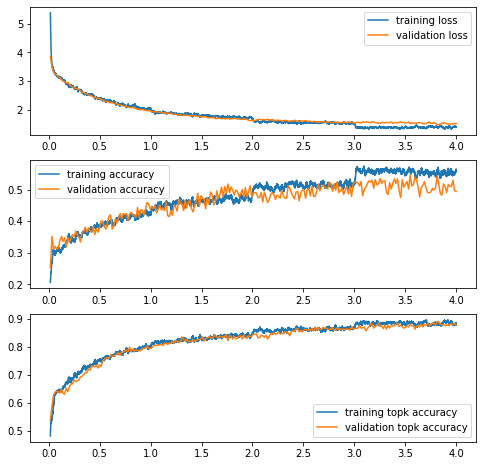

In [14]:
# Train model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

history = train_util.train_model(
    model,
    criterion,
    optimizer,
    train_loader,
    mini_valid_loader,
    epochs=4,
    valid_every=200,
)
train_util.plot_history(history)

In [ ]:
# Load pre-trained weight
train_util.load_model(model, "./models/bert_resnet152_mul_weights.pth")


## Test Model

In [10]:
# Accuracy on the mini validation set
mini_valid_loss, mini_valid_accu, mini_valid_topk_accu = train_util.validate_model(
    model, mini_valid_loader, nn.CrossEntropyLoss()
)
print("loss:", mini_valid_loss)
print("accu:", mini_valid_accu)
print("topk_accu:", mini_valid_topk_accu)


loss: 1.5221311748027802
accu: 0.546875
topk_accu: 0.875


In [17]:
# Accuracy on the full validation set
valid_loss, valid_accu, valid_topk_accu = train_util.validate_model(
    model, valid_loader, nn.CrossEntropyLoss(), show_progress=True
)
print("loss:", valid_loss)
print("accu:", valid_accu)
print("topk_accu:", valid_topk_accu)


4332/4332 [==============================] - 1562s 361ms/step
loss: 1.6463345320326028
accu: 0.49796199798583984
topk_accu: 0.8558402061462402


In [18]:
# Accuracy on the test set
test_loss, test_accu, test_topk_accu = train_util.validate_model(
    model, test_loader, nn.CrossEntropyLoss(), show_progress=True
)
print("loss:", test_loss)
print("accu:", test_accu)
print("topk_accu:", test_topk_accu)


1865/1865 [==============================] - 674s 361ms/step
loss: 1.6506108273449915
accu: 0.49343141913414
topk_accu: 0.8562116622924805


Q: [CLS] what color is the truck? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
A: blue
Model: blue


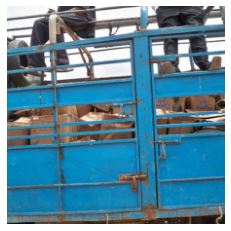

Q: [CLS] is it day or night? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
A: day
Model: day


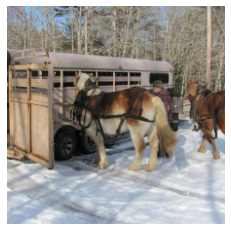

Q: [CLS] what color is the man's shirt? [SEP] [PAD] [PAD] [PAD]
A: brown
Model: gray


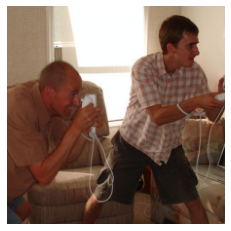

Q: [CLS] what color is the background? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
A: green
Model: green


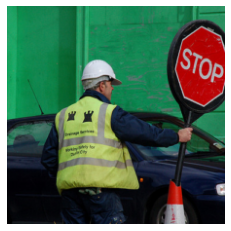

In [11]:
# Plot some samples
images, questions, answers = next(iter(test_loader))
model.eval()
with torch.no_grad():
    outputs = model(images, questions)
predictions = torch.argmax(outputs, dim=1).cpu()

for _, v, q, a, pred in zip(range(4), images, questions["input_ids"], answers, predictions):
    print("Q:", tokenizer.decode(q))
    print("A:", answer_vocab.itos[a])
    print("Model:", answer_vocab.itos[pred])
    helper.imshow(v.cpu())
    plt.show()
